
Numerical Results Table:
    Complexity  Completeness  Correctness  Verifiability  Feasibility  \
0          Low           0.3          0.3            0.3            0   
1          Low           0.3          0.3            0.3            1   
2          Low           0.3          0.3            0.6            0   
3          Low           0.3          0.3            0.6            1   
4          Low           0.3          0.3            0.9            0   
..         ...           ...          ...            ...          ...   
157       High           0.9          0.9            0.3            1   
158       High           0.9          0.9            0.6            0   
159       High           0.9          0.9            0.6            1   
160       High           0.9          0.9            0.9            0   
161       High           0.9          0.9            0.9            1   

     Total Delay (Days)  
0                 17.50  
1                 12.50  
2                 1

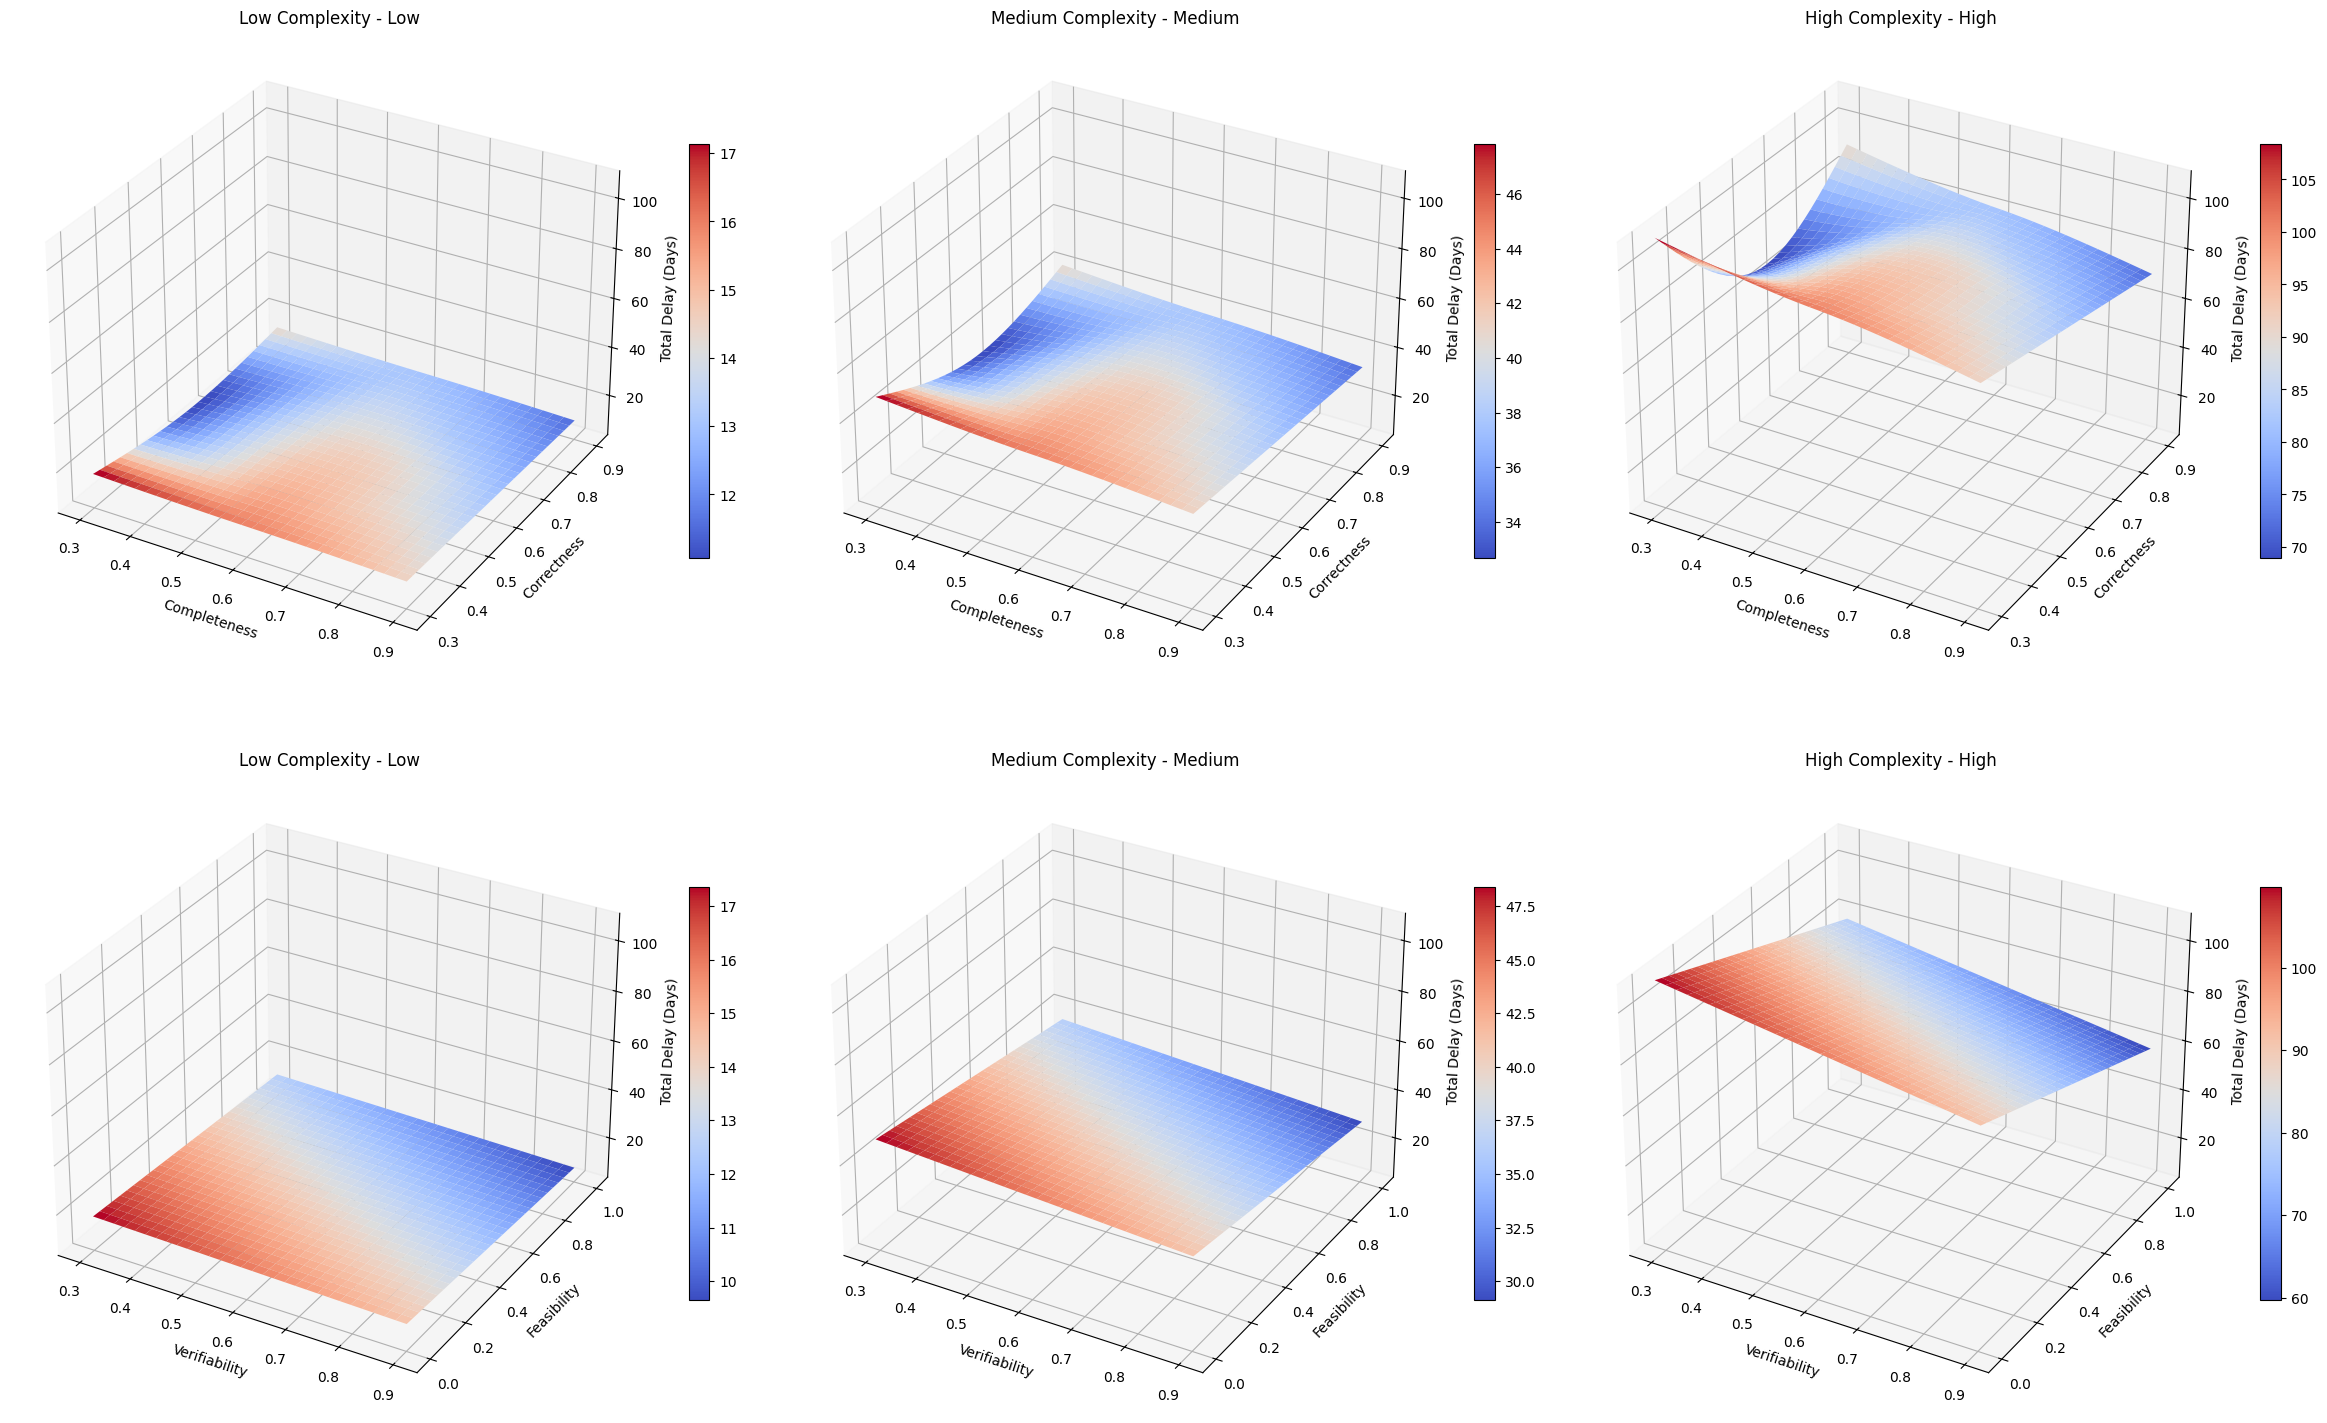

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

# Simulation Parameters
max_cycles = 50
requirements_per_sprint = 40
bug_fixing_probability = 0.3
initial_defect_rate = 0.15  # initial defect rate
defect_rate_reduction = 0.01  # defect rate reduction per cycle

# Fixed Quality Attributes (except Completeness & Correctness)
base_quality_attributes = {
    'Unambiguous': {'qf': 0.9, 'risk': 0.8, 'probability': 0.65},
    'Complete': {},
    'Correct': {},
    'Consistent': {'qf': 0.9, 'risk': 0.7, 'probability': 0.55},
    'Feasible': {},
    'Verifiable': {}
}

# Define Complexity Levels
complexity_levels = {'Low': 50, 'Medium': 200, 'High': 500}
completeness_levels = {'Low': 0.3, 'Medium': 0.6, 'High': 0.9}
correctness_levels = {'Low': 0.3, 'Medium': 0.6, 'High': 0.9}
verifiability_levels = {'Low': 0.3, 'Medium': 0.6, 'High': 0.9}
feasibility_levels = [0, 1]

# Store Results
results = []

# Loop through all combinations
for complexity_name, total_requirements in complexity_levels.items():
    for completeness_name, completeness_value in completeness_levels.items():
        for correctness_name, correctness_value in correctness_levels.items():
            for verifiability_name, verifiability_value in verifiability_levels.items():
                for feasibility in feasibility_levels:
                    # Update Quality Attributes
                    quality_attributes = base_quality_attributes.copy()
                    quality_attributes['Complete'] = {'qf': completeness_value, 'risk': 0.9, 'probability': 0.55}
                    quality_attributes['Correct'] = {'qf': correctness_value, 'risk': 1.0, 'probability': 0.75}
                    quality_attributes['Feasible'] = {'qf': feasibility, 'risk': 0.7, 'probability': 0.6}
                    quality_attributes['Verifiable'] = {'qf': verifiability_value, 'risk': 0.7, 'probability': 0.65}

                    # Initialize variables
                    remaining_requirements = total_requirements
                    project_delay = 0
                    cycle = 0
                    current_defect_rate = initial_defect_rate
                    total_defects = 0

                    # Simulation Loop
                    while remaining_requirements > 0 and cycle < max_cycles:
                        cycle += 1
                        implemented_requirements = min(remaining_requirements, requirements_per_sprint)

                        # Generate defects
                        defects_in_sprint = int(implemented_requirements * current_defect_rate)
                        total_defects += defects_in_sprint

                        # Fix defects
                        fixed_defects = int(defects_in_sprint * bug_fixing_probability)
                        total_defects -= fixed_defects
                        project_delay += fixed_defects * 2  # Delay for fixing defects.

                        # Calculate delay based on factors
                        delay_factor = (1 - completeness_value) + (1 - correctness_value) + (1 - verifiability_value) + (1 - feasibility)

                        # Weighted Delay using Risk and Probability
                        weighted_delay = delay_factor * 5

                        # Calculate the mean risk and probability
                        mean_risk = np.mean([attr['risk'] for attr in quality_attributes.values()])
                        mean_probability = np.mean([attr['probability'] for attr in quality_attributes.values()])

                        weighted_delay = weighted_delay * mean_risk * mean_probability

                        project_delay += weighted_delay

                        # Update remaining requirements
                        remaining_requirements -= implemented_requirements
                        current_defect_rate = max(0, current_defect_rate - defect_rate_reduction)

                    # Store results
                    results.append({
                        'Complexity': complexity_name,
                        'Completeness': completeness_value,
                        'Correctness': correctness_value,
                        'Verifiability': verifiability_value,
                        'Feasibility': feasibility,
                        'Total Delay (Days)': project_delay
                    })

# Convert to DataFrame
df_results = pd.DataFrame(results)

# Print the numerical table output
print("\nNumerical Results Table:")
print(df_results)

# Save to CSV file for further analysis
df_results.to_csv("simulation_results.csv", index=False)

# Determine Z-axis limits
z_delay_min, z_delay_max = df_results['Total Delay (Days)'].min(), df_results['Total Delay (Days)'].max()

# Generate 6 Separate 3D Surface Plots for meaningful combinations across complexity levels
fig, axes = plt.subplots(2, 3, figsize=(24, 16), subplot_kw={'projection': '3d'})

# Define grouped variables per complexity level
pairings = [
    ('Completeness', 'Correctness', 'Total Delay (Days)', 'coolwarm', 'Low Complexity', 'Low'),
    ('Completeness', 'Correctness', 'Total Delay (Days)', 'coolwarm', 'Medium Complexity', 'Medium'),
    ('Completeness', 'Correctness', 'Total Delay (Days)', 'coolwarm', 'High Complexity', 'High'),
    ('Verifiability', 'Feasibility', 'Total Delay (Days)', 'coolwarm', 'Low Complexity', 'Low'),
    ('Verifiability', 'Feasibility', 'Total Delay (Days)', 'coolwarm', 'Medium Complexity', 'Medium'),
    ('Verifiability', 'Feasibility', 'Total Delay (Days)', 'coolwarm', 'High Complexity', 'High')
]

def plot_surface(ax, x_var, y_var, z_var, cmap, title, complexity):
    df_subset = df_results[df_results['Complexity'] == complexity]
    grid_x, grid_y = np.meshgrid(
        np.linspace(df_subset[x_var].min(), df_subset[x_var].max(), 30),
        np.linspace(df_subset[y_var].min(), df_subset[y_var].max(), 30)
    )
    grid_z = griddata((df_subset[x_var], df_subset[y_var]), df_subset[z_var], (grid_x, grid_y), method='cubic')
    surf = ax.plot_surface(grid_x, grid_y, grid_z, cmap=cmap)
    ax.set_xlabel(x_var)
    ax.set_ylabel(y_var)
    ax.set_zlabel(z_var)
    ax.set_title(title)
    ax.set_zlim(z_delay_min, z_delay_max)  # Set consistent Z-axis scale
    fig.colorbar(surf, ax=ax, shrink=0.5)

# Plot grouped variables for each complexity level
for ax, (x_var, y_var, z_var, cmap, title, complexity) in zip(axes.flat, pairings):
    plot_surface(ax, x_var, y_var, z_var, cmap, f'{title} - {complexity}', complexity)

plt.tight_layout()
plt.show()